In [2]:
##########################################################################################################
## info: veilleux.karel@courrier.uqam.ca                                                                 #
# date: 2023-08                                                                                          #
# description: Some eco-regions taken from "https://www.narccap.ucar.edu/contrib/bukovsky/ seem dephased #
#              spatially. This code applies a land and ocean filter to all the eco-regions to remove the #
#              overlap that exists.                                                                      #
##########################################################################################################

In [3]:
import xesmf  as xe
import xarray as xr
import numpy  as np
import pandas as pd
import os
import yaml
import warnings
import netCDF4
import shutil

import cartopy.crs       as ccrs
import cartopy.feature   as cfeature
import matplotlib.cm     as cm
import matplotlib.pyplot as plt
from scipy import ndimage


warnings.filterwarnings("ignore")

working_directory = '/home/veilleux/Projet/Projet_SACHR/analyses_and_figures'
yml_file = working_directory + '/config.yml'
stream = open(yml_file,'r')
config = yaml.safe_load(stream)

In [45]:
def make_map(ncfile, pngfile, data, cmap, vext, title,showcolorbar=True):
    dpi = 150

    # Get lat, lon and cartopy_projection_object
    ds  = xr.open_dataset(ncfile)
    lat = ds.lat.values
    lon = ds.lon.values
    m   = ccrs.RotatedPole(ds.rotated_pole.grid_north_pole_longitude,
                           ds.rotated_pole.grid_north_pole_latitude)

    # Domain limites
    xll, yll = m.transform_point(lon[ 0,  0],lat[ 0,  0], ccrs.PlateCarree())
    xur, yur = m.transform_point(lon[-1, -1],lat[-1, -1], ccrs.PlateCarree())

    # Creating figure
    fig = plt.figure()
    fig.set_dpi(dpi)
    ax = plt.axes(projection=m)
    pc = ax.pcolormesh(lon, lat, data, cmap=cmap,vmin=vext[0], vmax=vext[1], transform=ccrs.PlateCarree())
    vext[0], vext[1] = pc.get_clim() # Useful when input was vext[0]=None and/or vext[1]=None

    # Domain limites
    ax.set_extent([xll, xur, yll, yur], crs=m)

    # Coastlines + political borders
    ax.coastlines(resolution='10m',linewidth = 0.3)
    L0_country_ALL = cfeature.NaturalEarthFeature(category='cultural',name='admin_1_states_provinces_lakes',scale='50m',facecolor='none')
    ax.add_feature(L0_country_ALL, edgecolor='black', linewidth = 0.2)

    # Title
    plt.title(title, fontsize=8)

    # Colorbar
    if showcolorbar == True:

        if   vext[0] ==  -vext[1]: extend = 'both'
        else                     : extend = 'neither'
        sm = plt.cm.ScalarMappable(cmap=cmap,norm=plt.Normalize(vext[0],vext[1]))
        sm._A = []
        plt.colorbar(sm,ax=ax, extend=extend)

    plt.show()

# Path and Grid data from GEM5 step0

In [5]:
#Step 0 GEM path to set lat and lon in cartopy
ncfile = config['GEM5']['step0']
# Get lat, lon and cartopy_projection_object
ds  = xr.open_dataset(ncfile)        # Dataframe from the netcdf file
lat = ds.lat.values                  # 2D array with latitude
lon = ds.lon.values                  # 2D array with longitude
mask = ds.MG.isel(time=0).values     # Land mask : 1 = land, 0 = ocean

land_mask  =     mask  # Land mask  : 1 = Land , 0 = Ocean (default in GEM 'MG' variable)
ocean_mask = 1 - mask  # Ocean mask : 1 = Ocean, 0 = Land

# Bukovsky original files directory
dir_in  = config['bukovsky']['chinook'] +'/'+ 'original'
# Bukovsky regridded output files directory
dir_out = config['bukovsky']['chinook'] +'/'+ 'regrid'

# Regriding and applying sea/land filter 

In [73]:
# Aquatic regions
ocean = ['Hudson.nc'    ,'ColdNEPacific.nc','GreatLakes.nc','WarmNEPacific.nc', 'WarmNWAtlantic.nc']
# Land regions
land =  ['Appalachia.nc','EastBoreal.nc'   ,'PacificNW.nc' ,'Southwest.nc'    , 'NPlains.nc']
# List of files in dir_in directory
nc_files_in = [file for file in os.listdir(dir_in) if file.endswith('.nc')]

nc = '/chinook/veilleux/DATA/Bukovsky/sealandmask.nc'
ds_mask  = xr.open_dataset(nc)
landmask = np.where( np.squeeze(ds_mask['mask'].values ) == 1, 1     , np.nan)
seamask  = np.where( np.squeeze(ds_mask['mask'].values ) == 1, np.nan,      1)

for file_name in nc_files_in: 
    filename = str(file_name.split('.')[0])
    file_path    = os.path.join(dir_in, file_name)
    
    og_ds = xr.open_dataset(file_path)

    new_lon = ds['lon']
    new_lat = ds['lat']

    #input('')
    # Create the regridder using xesmf
    #regridder = xe.Regridder(og_ds, {'lon': new_lon, 'lat': new_lat}, method='bilinear')
    
    regridder = xe.Regridder(og_ds, {'lon': new_lon, 'lat': new_lat}, method='nearest_s2d', periodic = True)

    # Perform the regridding for each variable
    regridded_vars = {}
    for var_name in og_ds.variables:
        if var_name not in ['lon', 'lat']:  # Skip lon and lat variables
            regridded_vars[var_name] = regridder(og_ds[var_name]) 
            regridded_vars[var_name] = regridded_vars[var_name].where(regridded_vars[var_name] != 0, np.nan) 

    # Create a new Dataset with regridded variables
    regridded_ds = xr.Dataset(regridded_vars)
    # if aquatic region, remove land grid points
    if   file_name in ocean:
        regridded_ds['mask'] = regridded_ds['mask'] * seamask
    # if land region   , remove ocean grid points
    elif file_name in land: 
        regridded_ds['mask'] = regridded_ds['mask'] * landmask
    # Output file path directory    
    output_file_path = dir_out + "/" + filename + ".nc"
    regridded_ds.to_netcdf(output_file_path)
    
    og_ds.close()
    regridded_ds.close()

KeyboardInterrupt: 

# Regridding method 2

In [125]:
# Aquatic regions
ocean = ['Hudson.nc'    ,'ColdNEPacific.nc','GreatLakes.nc','WarmNEPacific.nc', 'WarmNWAtlantic.nc']
# Sea regions
land =  ['Appalachia.nc','EastBoreal.nc'   ,'PacificNW.nc' ,'Southwest.nc'    , 'NPlains.nc']
# List of bukovsky files in dir_in directory
nc_files_in = [file for file in os.listdir(dir_in) if file.endswith('.nc')]

nc = '/chinook/veilleux/DATA/Bukovsky/sealandmask.nc'
ds_mask  = xr.open_dataset(nc)
landmask = np.where( np.squeeze(ds_mask['mask'].values ) == 1, 1     , np.nan) # Landmask
seamask  = np.where( np.squeeze(ds_mask['mask'].values ) == 1, np.nan,      1) # Seamask

ds  = netCDF4.Dataset(nc, 'r') # Dataframe from the sealand mask to copy dimensions and variables
for file_name in nc_files_in: 
    filename = str(file_name.split('.')[0])
    print(filename)
    ##############################
    ###  In & Out NetCDF file  ###
    ##############################
    ncfilei= os.path.join(dir_in, file_name)   # File in  directory
    ncfileo = dir_out + "/" + filename + ".nc" # File out directory
    
    nci = xr.open_dataset(ncfilei);
    nco = netCDF4.Dataset(ncfileo, 'w')
    
    # New longitudes and latitudes to regrid over
    new_lon = ds['lon']
    new_lat = ds['lat']
    
    # Copying dimensions
    nco.setncatts(ds.__dict__)  
    
    ###############################
    ###  Extraction dimensions  ###
    ###  in input files         ###
    ###############################
    varnames = ['time','leadtime','lon','lat','rlon','rlat','rotated_pole', 'mask']
    dimnames = []
    for varname in varnames:
        for dimname in ds.variables[varname].dimensions:
            dimnames.append(dimname)
    dimnames = set(dimnames)

    #############################
    ###  Creating dimensions  ###
    #############################
    for dimname in dimnames:
        dimension = ds.dimensions[dimname]
        if dimname == 'time':nco.createDimension(dimname, len(dimension))
        else                :nco.createDimension(dimname, (len(dimension) if not dimension.isunlimited() else None))   

    # Copying GEM5 variables
    for varname in varnames:
        variable = ds[varname]
        x = nco.createVariable(varname, variable.datatype, variable.dimensions, zlib=True, complevel=4)
        nco[varname].setncatts(variable.__dict__)
        nco[varname][:] = ds[varname][:]
   
    # Create the regridder using xesmf    
    regridder = xe.Regridder(nci, {'lat': new_lat,'lon': new_lon}, method='nearest_s2d', periodic = True)
    # Perform the regridding for each variable
    regridded_vars = {}
    regridded_vars['mask'] = regridder(nci['mask'])
    #regridded_vars['mask'] = regridded_vars['mask'].where(regridded_vars['mask'] != 0, np.nan)
    
    # Create a new Dataset with regridded variables
    new_mask = xr.Dataset(regridded_vars)

    ###################################
    ###################################

    # Applying mask to land and sea regions
    if   file_name in ocean:
        nco['mask'][:] = np.float32(new_mask['mask'].values) * seamask
        nco['mask'][:] = np.ma.masked_invalid(nco['mask'][:])
    elif file_name in land:
        nco['mask'][:] = np.float32(new_mask['mask'].values) * landmask
        nco['mask'][:] = np.ma.masked_invalid(nco['mask'][:])
    nci.close()
    nco.close()


Appalachia
ColdNEPacific
EastBoreal
GreatLakes
Hudson
NPlains
PacificNW
Southwest
WarmNEPacific
WarmNWAtlantic


# Final Adjustments sea and land mask

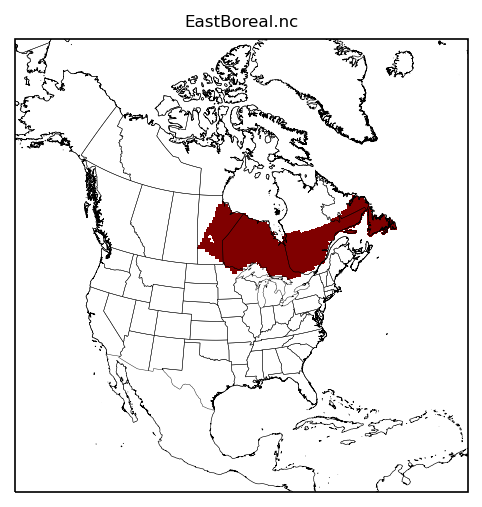

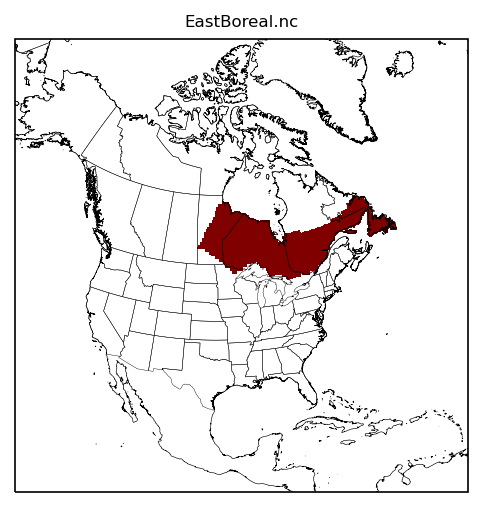

In [47]:
############################
###    Sea & Land mask   ###
############################
nc = '/chinook/veilleux/DATA/Bukovsky/sealandmask.nc'
ds_mask  = xr.open_dataset(nc)
landmask = np.where( np.squeeze(ds_mask['mask'].values ) == 1, 1     , np.nan) # Landmask
seamask  = np.where( np.squeeze(ds_mask['mask'].values ) == 1, np.nan,      1) # Seamask

cmap = cm.get_cmap('jet',1)
rootdir     = config['bukovsky']['chinook']
####################################################
###                                              ###
###               Sea eco-regions                ###
###                                              ###
####################################################

##########################
###    ColdNEPacific   ###
##########################
if 1 == 0:
    region='ColdNEPacific.nc'
    nci = rootdir + '/regrid/' +  region
    nco = rootdir + '/final/' +  region
    ds  = xr.open_dataset(nci)
    m   = np.squeeze(ds['mask'].values )
    make_map(nci, 'x', m, cmap, [0,1], region, showcolorbar=False)

    m = m * np.nan
    m[220:500,35:150] = 1
    m = m * seamask
    make_map(nci, 'x', m, cmap, [0,1], region, showcolorbar=False)
    
    # Pixel manquant Grand-Lacs
    region2   = 'PacificNW.nc'
    nci2      = rootdir + '/regrid/' +  region2
    ds2       = xr.open_dataset(nci2)
    m2        = np.squeeze(ds2['mask'].values )
    M         = np.where(~np.isnan(m2), m2, m)
    M         = ndimage.binary_fill_holes(~np.isnan(M)).astype(float)
    M[M == 0] = np.nan
    m         = np.where(m2==1, np.nan, M)
    
    ds['mask'].values[0,:,:] = m
    ds.to_netcdf(nco)
    make_map(nci, 'x', m3, cmap, [0,1], region, showcolorbar=False)

##########################
###    WarmNEPacific   ###
##########################
if 1 == 0:
    region='WarmNEPacific.nc'
    nci = rootdir + '/regrid/' +  region
    nco = rootdir + '/final/' +  region
    ds  = xr.open_dataset(nci)
    m   = np.squeeze(ds['mask'].values )
    make_map(nci, 'x', m, cmap, [0,1], region, showcolorbar=False)

    m = m * np.nan
    m[120:220,35:140] = 1
    m[120:170,35:150] = 1
    m[120:140,35:160] = 1
    m = m * seamask

    ds['mask'].values[0,:,:] = m
    ds.to_netcdf(nco)
    make_map(nci, 'x', m, cmap, [0,1], region, showcolorbar=False)

##########################
###   WarmNWAtlantic   ###
##########################
if 1 == 0:
    region='WarmNWAtlantic.nc'
    nci = rootdir + '/regrid/' +  region
    nco = rootdir + '/final/' +  region
    ds  = xr.open_dataset(nci)
    m   = np.squeeze(ds['mask'].values )
    make_map(nci, 'x', m, cmap, [0,1], region, showcolorbar=False)

    m = m * np.nan
    m[121:230,290:550] = 1
    m = m * seamask
    ds['mask'].values[0,:,:] = m

    ds.to_netcdf(nco)
    make_map(nci, 'x', m, cmap, [0,1], region, showcolorbar=False)

##########################
###       Hudson       ###
##########################
if 1 == 0:
    region='Hudson.nc'
    nci = rootdir + '/regrid/' +  region
    nco = rootdir + '/final/' +  region
    ds  = xr.open_dataset(nci)
    m   = np.squeeze(ds['mask'].values )
    make_map(nci, 'x', m, cmap, [0,1], region, showcolorbar=False)

    #m = m * np.nan
    m[350:450,300:400] = 1
    m = m * seamask
    
    ds['mask'].values[0,:,:] = m
    ds.to_netcdf(nco)
    make_map(nci, 'x', m, cmap, [0,1], region, showcolorbar=False)

##########################
###    Great Lakes     ###
##########################
if 1 == 0:
    region='GreatLakes.nc'
    nci = rootdir + '/regrid/' +  region
    nco = rootdir + '/final/' +  region
    ds  = xr.open_dataset(nci)
    m   = np.squeeze(ds['mask'].values )
    make_map(nci, 'x', m, cmap, [0,1], region, showcolorbar=False)

    m = m * np.nan
    m[250:330,300:425] = 1
    m = m * seamask
    make_map(nci, 'x', m, cmap, [0,1], region, showcolorbar=False)

    m = ndimage.binary_closing(~np.isnan(m)).astype(float)
    m[m == 0] = np.nan

    m = ndimage.binary_fill_holes(~np.isnan(m)).astype(float)
    m[m == 0] = np.nan

    ds['mask'].values[0,:,:] = m
    ds.to_netcdf(nco)
    make_map(nci, 'x', m, cmap, [0,1], region, showcolorbar=False)

####################################################
###                                              ###
###              Land eco-regions                ###
###                                              ###
####################################################
    
##########################
###     Appalachia     ###
##########################
if 1 == 0:
    region='Appalachia.nc'
    nci = rootdir + '/regrid/' +  region
    nco = rootdir + '/final/' +  region
    ds  = xr.open_dataset(nci)
    m   = np.squeeze(ds['mask'].values )
    make_map(nci, 'x', m, cmap, [0,1], region, showcolorbar=False)

    region2='GreatLakes.nc'
    nci2 = rootdir + '/final/' +  region2
    ds2  = xr.open_dataset(nci2)
    m2   = np.squeeze(ds2['mask'].values )
    make_map(nci, 'x', m2, cmap, [0,1], region, showcolorbar=False)

    m = np.where(m2==1, np.nan, m)

    ds['mask'].values[0,:,:] = m
    ds.to_netcdf(nco)

##########################
###      Nplains       ###
##########################
if 1==0:
    region = 'NPlains.nc'
    nci = rootdir + '/regrid/' +  region
    nco = rootdir + '/final/' +  region
    shutil.copy(nci, nco)
    
##########################
###     PacificNW      ###
##########################
if 1 == 0:
    region='PacificNW.nc'
    nci = rootdir + '/regrid/' +  region
    nco = rootdir + '/final/' +  region
    shutil.copy(nci, nco)

##########################
###     Southwest      ###
##########################   
if 1 == 0:
    region='Southwest.nc'
    nci = rootdir + '/regrid/' +  region
    nco = rootdir + '/final/' +  region
    ds  = xr.open_dataset(nci)
    m   = np.squeeze(ds['mask'].values )
    
    m = m * landmask
    m[115:141,170:175] =  np.nan
    m[120:141,167:175] =  np.nan
    m[154:170,153:163] =  np.nan
    m[105:120,90:250]  =  np.nan
    
    ds['mask'].values[0,:,:] = m
    ds.to_netcdf(nco)
    make_map(nci, 'x', m, cmap, [0,2], region, showcolorbar=False)

##########################
###     EastBoreal     ###
##########################    
if 1 == 0:
    region='EastBoreal.nc'
    nci = rootdir + '/regrid/' +  region
    nco = rootdir + '/final/' +  region
    ds  = xr.open_dataset(nci)
    m   = np.squeeze(ds['mask'].values ) 
    make_map(nci, 'x', m, cmap, [0,2], region, showcolorbar=False)

    # Pixels manquant baie d'hudson
    xi = 300; yi = 375;  
    xf = 373; yf = 420;
    m[yi:yf,xi:xf] =  landmask[yi:yf,xi:xf]

    # Pixels manquant au nord de l'estiare du St-laurent
    xi = 450; yi = 350;
    xf = 455; yf = 365;
    m[yi:yf,xi:xf] =  landmask[yi:yf,xi:xf]

    xi = 454; yi = 358;
    xf = 460; yf = 365;
    m[yi:yf,xi:xf] =  landmask[yi:yf,xi:xf]

    xi = 459; yi = 360;
    xf = 462; yf = 366;
    m[yi:yf,xi:xf] =  landmask[yi:yf,xi:xf]

    # Pixel manqants au nors du fleuve st-laurent
    xi = 440; yi = 345;
    xf = 452; yf = 350;
    m[yi:yf,xi:xf] =  1

    xi = 440; yi = 340;
    xf = 451; yf = 345;
    m[yi:yf,xi:xf] =  1

    xi = 440; yi = 337;
    xf = 450; yf = 340;
    m[yi:yf,xi:xf] =  1

    xi = 440; yi = 333;
    xf = 448; yf = 337;
    m[yi:yf,xi:xf] =  1

    # Pixels excédentaire au sud du fleuve st-laurent
    xi = 446; yi = 332;
    xf = 449; yf = 334;
    m[yi:yf,xi:xf] =  np.nan

    xi = 445; yi = 331;
    xf = 447; yf = 333;
    m[yi:yf,xi:xf] =  np.nan
    
    # Pixel in sea near Saint-Pierre and Miquelon
    xi =525; yi =370 
    xf =535; yf =376
    m[yi:yf,xi:xf] =  np.nan

    # Lacs à l,intérieur du domaine (Winnipeg, Nippigon, St-Jean, etc)
    m = ndimage.binary_fill_holes(~np.isnan(m)).astype(float)
    m[m == 0] = np.nan

    # Pixel manquant Grand-Lacs
    region2='GreatLakes.nc'
    nci2 = rootdir + '/final/' +  region2
    ds2  = xr.open_dataset(nci2)
    m2   = np.squeeze(ds2['mask'].values )

    #m = m * np.nan
    #xi = 370; yi = 310;
    #xf = 400; yf = 320;
    #m[yi:yf,xi:xf] =  1
    m = np.where(m2==1, np.nan, m)

    #m = m * np.nan
    #xi = 320; yi = 325;
    #xf = 350; yf = 333;
    #m[yi:yf,xi:xf] =  1
    m = np.where(m2==1, np.nan, m)

    #m = m * np.nan
    #xi = 320; yi = 317;
    #xf = 337; yf = 325;
    #m[yi:yf,xi:xf] =  1
    m = np.where(m2==1, np.nan, m)
    
    # Missing pixel near Montreal
    xi =428; yi =320 
    xf =437; yf =330
    m[yi:yf,xi:xf] =  landmask[yi:yf,xi:xf]
    
    xi =415; yi =315 
    xf =425; yf =320
    m[yi:yf,xi:xf] =  landmask[yi:yf,xi:xf]
    
    M    = np.where(~np.isnan(m2), m2, m)
    M = ndimage.binary_fill_holes(~np.isnan(M)).astype(float)
    M[M == 0] = np.nan
    m = np.where(m2==1, np.nan, M)

    
   # m = m * landmask
    
    make_map(nci, 'x', m, cmap, [0,2], region, showcolorbar=False)

    ds['mask'].values[0,:,:] = m
    ds.to_netcdf(nco)